### Prepare Data

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


In [4]:
DATA_ROOT = "/ysm-gpfs/project/smz25/CHUD/"

In [5]:
sample_var_phenos_file = DATA_ROOT + "sample_var_phenos_leuk_topmed_v2.feather"
sample_var_phenos = pd.read_feather(sample_var_phenos_file)

sample_var_phenos.shape
sample_var_phenos.drop(columns=['All_Pneumonia', 'AgeAt_All_Pneumonia', 'Incd_All_Pneumonia', 'All_Pneumonia_FollowUp', 'Prev_All_Pneumonia', 'sampleID', "id"], inplace = True)
sample_var_phenos.drop(sample_var_phenos.filter(regex = 'Prev\_|Incd\_|\_FollowUp', axis="columns"), axis = 1, inplace = True)

In [6]:
sample_var_phenos.shape

(38070, 2581)

In [7]:
# 'Hypercholesterolemia',
# 'Hypertension',
# 'hasCHIP',
# 'AML',
# 'MPN',
# 'SmokingStatus',
# 'ever_smoked',
# 'Coronary_Artery_Disease_SOFT',
# 'Heart_Failure',





In [8]:
sample_phenos_onehot = pd.get_dummies(sample_var_phenos , columns=["CHIP_Gene", "AD"])

In [9]:
sample_phenos_onehot.shape[1] - sample_var_phenos.shape[1]


811

In [10]:
sample_phenos_onehot.loc[:, "AML"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
38065    0.0
38066    0.0
38067    0.0
38068    0.0
38069    0.0
Name: AML, Length: 38070, dtype: float64

Do the imputation before we move forward. First drop rows with NA PCs

In [11]:
sample_phenos_onehot.dropna(subset=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"], inplace=True)
sample_phenos_onehot.shape

(38017, 3392)

In [12]:
fillnavals = {"Heart_Failure":0, "AF":0, "AML":0, "MPN":0}
sample_phenos_onehot.fillna(value=fillnavals)
sample_phenos_onehot.shape

(38017, 3392)

In [13]:
all_except_class = sample_phenos_onehot.columns[sample_phenos_onehot.columns != "AML"]

X = sample_phenos_onehot.loc[:, all_except_class]
Y = np.array(sample_phenos_onehot.loc[:, "AML"])
print(X.shape)
print(Y.shape)

(38017, 3391)
(38017,)


In [14]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')


In [15]:
X = imp.fit_transform(X)

In [16]:
nanargs = np.argwhere(np.isnan(X))

print(nanargs)
nanargs[:, 1]
print(np.unique(nanargs[:,1]).size)
sample_phenos_onehot.dtypes.iloc[list(np.unique(nanargs[:,1]))]
sample_phenos_onehot.iloc[:, list(np.unique(nanargs[:,1]))].isna().sum()

[]
0


Series([], dtype: float64)

In [17]:
X.shape
# print(np.any(np.isnan(X)))

(38017, 3391)

In [18]:
# sample_phenos_onehot.iloc[:, np.unique(nanargs[:,1])]


In [19]:
# pca = PCA(n_components=3)
# X = pca.fit_transform(X)


In [20]:
# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plt.cla()
# pca.fit(X)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25471, 3391)
(12546, 3391)
(25471,)
(12546,)


## Oversample data 

In [23]:
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

from collections import Counter 


In [24]:
# del sample_phenos_onehot
# del sample_var_phenos
# del nanargs


In [25]:
counter = Counter(y_train)
print(counter)

Counter({0.0: 25436, 1.0: 35})


In [26]:
sampler = ADASYN(sampling_strategy="minority", n_jobs=3)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

In [27]:
print(sorted(Counter(y_train_resampled).items()))


[(0.0, 25436), (1.0, 25445)]


# SGD


In [28]:
from sklearn.linear_model import SGDClassifier

sgdregr = SGDClassifier(
    loss="log", 
    penalty="elasticnet",
    l1_ratio=0.5,
    n_jobs=-1,
    random_state=30,
    class_weight="balanced",
    # verbose=100,
    )



# dump(sgdregr, 'sample_var_phenos_leuk_somatic_topmed_v2_elasticlogreg.joblib') 




In [29]:
sgdregr.fit(X_train_resampled, y_train_resampled)

print("Completed Training: Elastic Net LogReg")


Completed Training: Elastic Net LogReg


In [30]:
y_hat = sgdregr.predict(X_test)


In [45]:
importancedf = pd.DataFrame(columns = sample_phenos_onehot.loc[:, all_except_class].columns)
importancedf.loc[len(importancedf)] = sgdregr.coef_[0]
importancedf.sort_values(by=0, axis=1, ascending=False)
# importancedf.to_csv(DATA_FILE + "_" + PREDICTION_PHENO +"_logreg_coef.csv" , index=False, float_format='%.8f', mode="a", )


# print(f"Elastic Net LogReg Accuracy: {sum(yhat_rounded == y_test)/len(yhat_rounded)}")
# print(f"Elastic Net LogReg Precision: {precision_score(y_test, yhat_rounded)}")
# print(f"Elastic Net LogReg Recall: {recall_score(y_test, yhat_rounded)}")


,Platelet distribution width,MPN,Coronary_Artery_Disease_SOFT,PC2,PC1,Hypertension,Diabetes_All,Death,Diabetes_Type_2,Sex_numeric,Heart_Failure,hasCHIP,PC6,chr10:110575336:C:A,CHIP_Gene_TET2,chr15:90085283:G:T,SmokingStatus,ever_smoked,chr17:7674292:T:A,chrX:48792204:T:C,chr17:76736877:G:T,PC5,chr20:32435686:CTGAGTCCTCACGG:C,PC10,"AD_137,27",chr2:25247628:C:T,"AD_78,5",chr20:32434485:C:A,"AD_32,11",chr4:105237276:C:CTAGA,chr4:105243780:T:G,"AD_28,3",chr4:105236448:AAC:A,chr2:25744457:G:GA,"AD_30,23",CHIP_Gene_DNMT3A,Diabetes_Type_1,AF,age2,chrX:124066173:A:G,chrX:124037556:C:A,chrX:124045268:T:TATCATATACTC,chrX:124045276:A:G,chrX:124045280:TG:T,chrX:124045360:C:A,chrX:124063934:C:A,chrX:124063184:T:A,chrX:124045360:C:T,chrX:124063191:G:T,chrX:124047438:A:T,chrX:124050278:T:A,chrX:124050293:G:A,chrX:124051119:A:T,chrX:124061770:G:T,chrX:124061788:G:T,chrX:124063926:A:T,chr9:5090785:C:T,chr9:5080548:G:T,chrX:124030966:TA:T,chr9:5090818:G:C,chr9:5090839:G:T,chr9:5123031:C:A,chr9:5090785:C:A,chr9:5090749:A:G,chr9:5090570:G:C,chr9:5090541:C:A,chr9:5090524:G:A,chr9:5090505:C:A,chr9:5089740:G:A,chr9:5089700:C:A,chrX:124066217:C:A,chr9:5080632:A:G,chr9:5080591:C:A,chr9:5080570:C:A,chr9:5123083:C:A,chr9:5090810:CG:C,chr9:5126384:C:T,chr9:5126400:T:A,chr9:5126696:A:G,chr9:5126745:A:T,chr9:5123116:C:A,chrX:130014218:GTCCTACCT:G,chrX:124066434:A:T,chrX:130055948:AC:A,chrX:130037381:C:A,chrX:130037434:C:A,chrX:130039151:C:A,chrX:130039172:A:G,chrX:130039183:C:A,chrX:130039189:C:A,chrX:130039193:C:A,chrX:130050778:C:A,chrX:130051911:C:A,chrX:130055853:G:T,chrX:134377682:C:A,chrX:124068623:C:A,chrX:134377718:C:A,chrX:134377739:C:A,chrX:134377741:C:T,chrX:134377752:C:A,chrX:134393572:C:A,chrX:134393575:C:A,chrX:134393925:C:A,chrX:134413873:T:A,chrX:134413882:C:A,chrX:134413890:G:C,chrX:130034660:C:T,chrX:130034657:C:T,chrX:130034633:C:A,chrX:130028740:C:A,chrX:124071148:G:T,chrX:124081482:G:T,chrX:124083473:C:A,chrX:124090580:G:T,chrX:124090645:GCAGACAC:G,chrX:124090646:C:T,chrX:124094056:C:A,chrX:130005255:C:A,chrX:130013605:C:A,chrX:130014216:C:CAGGTAGGA,chr9:5080331:A:T,chrX:130014809:C:A,chrX:130014939:C:A,chrX:130015270:G:A,chrX:130015280:C:A,chrX:130021042:TCAGA:T,chrX:130021049:C:A,chrX:130022895:A:T,chrX:130022908:A:T,chrX:130025109:A:T,chrX:130025304:C:T,chr9:5080382:T:A,chr9:5072491:G:T,chr9:5078436:C:A,chr7:148846580:G:T,chr7:148816704:C:A,chr7:148817393:T:A,chr7:148819650:G:T,chr7:148819687:G:T,chr7:148826513:G:A,chr7:148826514:T:C,chr7:148826595:G:A,chr7:148827267:C:G,chr7:148829777:G:T,chr7:148829827:G:C,chr7:148847253:G:A,chr8:116854370:C:A,chr8:116847523:C:T,chr8:116847661:T:TA,chr8:116852021:G:T,chr8:116852098:T:C,chr8:116852709:C:A,chr8:116854252:A:T,chr8:116854253:G:T,chr8:116854279:G:T,chr8:116854339:G:T,chr8:116854342:G:A,chr7:148814973:G:T,chr7:148814129:G:A,chr7:148814024:C:T,chr7:148811652:A:AT,chr7:140781603:C:T,chr7:140781642:G:T,chr7:140783130:G:T,chr7:140794306:A:T,chr7:140794360:G:T,chr7:140794409:G:A,chr7:140794468:C:A,chr7:140801411:C:T,chr7:140801484:G:T,chr7:140801488:G:A,chr7:140807968:G:T,chr7:140807979:G:T,chr7:140808012:T:A,chr7:140808036:G:T,chr7:140808041:C:T,chr7:140834839:G:T,chr7:140850127:G:T,chr7:140924618:GC:G,chr7:148809149:A:C,chr7:148810337:G:T,chr7:148810359:C:T,chr8:116854346:C:T,chr8:116856264:G:T,chr9:5078427:C:T,chr9:5069095:C:A,chr9:5064911:C:A,chr9:5064917:C:A,chr9:5064962:C:T,chr9:5065040:C:A,chr9:5065041:G:A,chr9:5066727:CTG:C,chr9:5069062:A:T,chr9:5069081:C:A,chr9:5069085:C:A,chr9:5069086:T:C,chr9:5069154:C:T,chr8:116856289:C:A,chrX:134413944:C:A,chr9:5072507:C:A,chr9:5072510:G:T,chr9:5072516:T:A,chr9:5072517:T:A,chr9:5072534:G:T,chr9:5072535:G:T,chr9:5073768:G:A,chr9:5078415:G:T,chr9:5078427:C:A,chr9:5064881:A:T,chr9:5054844:C:A,chr9:5054579:C:T,chr9:5054561:A:T,chr8:116856648:G:T,chr8:116861942:T:C,chr8:116863221:CA:C,chr8:116863243:C:T,chr8:116866593:G:T,chr8:116866721:G:T,chr9:5022003:C:A,chr9:5022102:C:A,chr9:5029782:G:T,chr9:5029816:T:A,chr9:5029825:A:T,chr9:5029853:C:A,chr9:5029

In [41]:
sgdregr.coef_[0, :]

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
sample_phenos_onehot.loc[:, all_except_class].columns.shape

(3391,)

## Elastic Net Log Reg

In [195]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

In [196]:
regr = ElasticNet(#cv=5, 
                    random_state=0,
#                     verbose=2,
#                     selection='random',
#                     n_jobs=-1
                   )
regr.fit(X_train_resampled, y_train_resampled)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [197]:
y_hat = regr.predict(X_test)


In [158]:
from joblib import dump, load
dump(regr, 'sample_var_phenos_leuk_somatic_topmed_v2_elasticlogreg.joblib') 

['sample_var_phenos_leuk_somatic_topmed_v2_elasticlogreg.joblib']

In [198]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


In [199]:
yhat_rounded = np.where(y_hat > 0.5, 1, 0)

In [200]:
sum(y_test == yhat_rounded)/len(y_test)

0.5302088315000797

In [201]:
np.nan_to_num(y_test, copy=False)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0.

In [202]:
np.isnan(y_test).any()
np.isnan(yhat_rounded).any()

False

In [203]:
# disp = plot_precision_recall_curve(regr, X_test, y_test)
# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))

precision_score(y_test, yhat_rounded)

0.0015256823190371248

In [204]:
recall_score(y_test, yhat_rounded)

0.75

In [205]:
sum(y_test == 0)

12534

In [206]:
sum(yhat_rounded == 0)

6647

In [210]:
sample_phenos_onehot.loc[:, all_except_class].columns
# np.array(sample_phenos_onehot.loc[:, "AML"])
# df = pd.DataFrame(data=clf.feature_importances_, columns = sample_phenos_onehot.loc[:, all_except_class].columns)
testdf = pd.DataFrame(columns = sample_phenos_onehot.loc[:, all_except_class].columns)
testdf.loc[len(testdf)] = regr.coef_
# testdf.sort_values(by=list(sample_phenos_onehot.loc[:, all_except_class].columns), axis=1)
testdf.sort_values(by=0, axis=1, ascending=False)

,age2,chr10:110569005:A:G,chrX:124061770:G:T,chrX:124030966:TA:T,chrX:124037556:C:A,chrX:124045268:T:TATCATATACTC,chrX:124045276:A:G,chrX:124045280:TG:T,chrX:124045360:C:A,chrX:124045360:C:T,chrX:124047438:A:T,chrX:124050278:T:A,chrX:124050293:G:A,chrX:124051119:A:T,chrX:124061788:G:T,chr9:5126696:A:G,chrX:124063184:T:A,chrX:124063191:G:T,chrX:124063926:A:T,chrX:124063934:C:A,chrX:124066173:A:G,chrX:124066217:C:A,chrX:124066434:A:T,chrX:124068623:C:A,chrX:124071148:G:T,chrX:124081482:G:T,chr9:5126745:A:T,chr9:5126400:T:A,chrX:124090580:G:T,chr9:5090524:G:A,chr9:5078436:C:A,chr9:5080331:A:T,chr9:5080382:T:A,chr9:5080548:G:T,chr9:5080570:C:A,chr9:5080591:C:A,chr9:5080632:A:G,chr9:5089700:C:A,chr9:5089740:G:A,chr9:5090505:C:A,chr9:5090541:C:A,chr9:5126384:C:T,chr9:5090570:G:C,chr9:5090749:A:G,chr9:5090785:C:A,chr9:5090785:C:T,chr9:5090810:CG:C,chr9:5090818:G:C,chr9:5090839:G:T,chr9:5123031:C:A,chr9:5123083:C:A,chr9:5123116:C:A,chrX:124083473:C:A,chrX:124090645:GCAGACAC:G,chr9:5078427:C:A,chrX:124090646:C:T,chrX:130050778:C:A,chrX:130051911:C:A,chrX:130055853:G:T,chrX:130055948:AC:A,chrX:134377682:C:A,chrX:134377718:C:A,chrX:134377739:C:A,chrX:134377741:C:T,chrX:134377752:C:A,chrX:134393572:C:A,chrX:134393575:C:A,chrX:134393925:C:A,chrX:134413873:T:A,chrX:134413882:C:A,chrX:134413890:G:C,chrX:134413904:G:C,chrX:134413944:C:A,chrX:134415014:A:T,chrX:134417202:A:T,chrX:134417287:C:A,chrX:134425217:C:A,chrX:134425244:G:A,chrX:134425257:G:T,chrX:130039193:C:A,chrX:130039189:C:A,chrX:130039183:C:A,chrX:130021049:C:A,chrX:124094056:C:A,chrX:130005255:C:A,chrX:130013605:C:A,chrX:130014216:C:CAGGTAGGA,chrX:130014218:GTCCTACCT:G,chrX:130014809:C:A,chrX:130014939:C:A,chrX:130015270:G:A,chrX:130015280:C:A,chrX:130021042:TCAGA:T,chrX:130022895:A:T,chrX:130039172:A:G,chrX:130022908:A:T,chrX:130025109:A:T,chrX:130025304:C:T,chrX:130028740:C:A,chrX:130034633:C:A,chrX:130034657:C:T,chrX:130034660:C:T,chrX:130037381:C:A,chrX:130037434:C:A,chrX:130039151:C:A,chr9:5078427:C:T,chr9:5078415:G:T,chrX:155071633:G:A,chr8:116854279:G:T,chr7:148810359:C:T,chr7:148811652:A:AT,chr7:148814024:C:T,chr7:148814129:G:A,chr7:148814973:G:T,chr7:148816704:C:A,chr7:148817393:T:A,chr7:148819650:G:T,chr7:148819687:G:T,chr7:148826513:G:A,chr7:148826514:T:C,chr7:148826595:G:A,chr7:148827267:C:G,chr7:148829777:G:T,chr7:148829827:G:C,chr7:148846580:G:T,chr7:148847253:G:A,chr8:116847523:C:T,chr8:116847661:T:TA,chr8:116852021:G:T,chr8:116852098:T:C,chr8:116852709:C:A,chr8:116854252:A:T,chr7:148810337:G:T,chr7:148809149:A:C,chr7:140924618:GC:G,chr7:140794360:G:T,chr7:140753354:T:C,chr7:140776934:G:C,chr7:140776998:G:T,chr7:140777018:G:T,chr7:140777021:T:A,chr7:140777057:T:C,chr7:140781603:C:T,chr7:140781642:G:T,chr7:140783130:G:T,chr7:140794306:A:T,chr7:140794409:G:A,chr7:140850127:G:T,chr7:140794468:C:A,chr7:140801411:C:T,chr7:140801484:G:T,chr7:140801488:G:A,chr7:140807968:G:T,chr7:140807979:G:T,chr7:140808012:T:A,chr7:140808036:G:T,chr7:140808041:C:T,chr7:140834839:G:T,chr8:116854253:G:T,chr8:116854339:G:T,chr9:5073770:G:T,chr8:116854342:G:A,chr9:5054579:C:T,chr9:5054844:C:A,chr9:5064881:A:T,chr9:5064911:C:A,chr9:5064917:C:A,chr9:5064962:C:T,chr9:5065040:C:A,chr9:5065041:G:A,chr9:5066727:CTG:C,chr9:5069062:A:T,chr9:5069081:C:A,chr9:5069085:C:A,chr9:5069086:T:C,chr9:5069095:C:A,chr9:5069154:C:T,chr9:5072491:G:T,chr9:5072507:C:A,chr9:5072510:G:T,chr9:5072516:T:A,chr9:5072517:T:A,chr9:5072534:G:T,chr9:5072535:G:T,chr9:5073768:G:A,chr9:5054561:A:T,chr9:5050770:G:T,chr9:5050768:T:A,chr9:5022003:C:A,chr8:116854346:C:T,chr8:116854370:C:A,chr8:116856264:G:T,chr8:116856289:C:A,chr8:116856648:G:T,chr8:116861942:T:C,chr8:116863221:CA:C,chr8:116863243:C:T,chr8:116866593:G:T,chr8:116866721:G:T,chr9:5022102:C:A,chr9:5050762:C:A,chr9:5029782:G:T,chr9:5029816:T:A,chr9:5029825:A:T,chr9:5029853:C:A,chr9:5029876:C:A,chr9:5029898:C:A,chr9:5044508:C:A,chr9:5044510:T:TGAGCAAAGAGGTAAGA,chr9:5044518:C:A,chr9:5050752:C:A,chrX:155071593:T:A,chrX:155077215:C:T,chrX:53415160:T:A,chrX:53380640:G:T,chr

## Random Forests


In [117]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


In [118]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, 
                             random_state=0,
                             verbose=100, 
                             #class_weight="balanced_subsample",
                             class_weight={0: 0.2, 1: 0.8},
                             max_samples=1000,
                             n_jobs=3)


In [119]:
np.nan_to_num(y_test, copy=False)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0.

In [120]:
clf.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100building tree 5 of 100building tree 6 of 100


[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    0.0s
building tree 7 of 100
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    0.0s
building tree 8 of 100
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    0.1s
building tree 9 of 100
building tree 10 of 100[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:    0.1s
building tree 11 of 100
building tree 12 of 100[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:    0.1s
building tree 13 of 100
building 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.2, 1: 0.8}, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       max_samples=1000, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=3, oob_score=False,
                       random_state=0, verbose=100, warm_start=False)

In [121]:
yhat = clf.predict(X_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    0.0s
[Para

In [122]:
sum(yhat == y_test)/len(yhat)

0.0009564801530368245

In [123]:
precision_score(y_test, yhat)


0.0009564801530368245

In [124]:
recall_score(y_test, yhat)


1.0

In [ ]:
from joblib import dump, load

dump(clf, 'sample_var_phenos_leuk_somatic_topmed_v2_elasticrandforest_resampled.joblib') 

In [125]:
import sys
np.set_printoptions(threshold=sys.maxsize)


clf.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.67937615e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [135]:
sample_phenos_onehot.loc[:, all_except_class].columns
# np.array(sample_phenos_onehot.loc[:, "AML"])
# df = pd.DataFrame(data=clf.feature_importances_, columns = sample_phenos_onehot.loc[:, all_except_class].columns)
testdf = pd.DataFrame(columns = sample_phenos_onehot.loc[:, all_except_class].columns)
testdf.loc[len(testdf)] = clf.feature_importances_
# testdf.sort_values(by=list(sample_phenos_onehot.loc[:, all_except_class].columns), axis=1)
testdf.sort_values(by=0, axis=1, ascending=False)

,PC4,PC10,SmokingStatus,Hypertension,PC9,Death,chr17:76736877:G:T,age2,AF,age,ever_smoked,PC6,Diabetes_Type_2,MPN,Sex_numeric,chr15:90085283:G:T,chr17:7674292:T:A,PC7,Heart_Failure,Coronary_Artery_Disease_SOFT,hasCHIP,PC8,id,PC1,CHIP_Gene_TET2,PC3,CHIP_Gene_DNMT3A,chrX:48792204:T:C,chr20:32435686:CTGAGTCCTCACGG:C,chr4:105236448:AAC:A,chr4:105237276:C:CTAGA,"AD_78,5",chr2:25744457:G:GA,"AD_137,27",Platelet distribution width,"AD_32,11",Platelet count,Platelet crit,Hypercholesterolemia,"AD_89,16","AD_30,23",chr2:25243931:G:A,chrX:53405077:G:A,chrX:130028740:C:A,chr2:208239975:G:T,chr21:34892930:A:T,chr3:136521221:G:T,chrX:45070327:C:A,"AD_46,3",chr20:32434582:G:GT,chr1:150959260:C:A,chr4:105236304:GAA:G,"AD_49,6",chr6:79026038:C:T,"AD_45,3",chr12:112450416:A:T,chr17:60647946:C:T,"AD_61,11",chr2:25244654:T:C,chr2:25240434:GAGCCGGCC:G,"AD_73,3",chr2:25244263:C:G,"AD_120,13","AD_62,9","AD_51,4","AD_84,5",PC5,PC2,Diabetes_All,chr20:32434485:C:A,Diabetes_Type_1,chrX:40057200:A:T,"AD_57,11",chr16:3850383:C:T,chr2:25240675:AGG:A,chr4:54733141:T:A,chrX:53403854:G:T,"AD_61,4","AD_48,8",chr6:78961755:G:T,chr12:112489068:C:T,chr2:208239158:G:T,chr2:197402592:G:T,chr12:112450344:A:T,chr9:5123083:C:A,"AD_58,3","AD_73,5","AD_46,14",chr13:28070527:ATTGTTCT:A,chr2:25245252:C:T,"AD_69,6","AD_18,3",chrX:134393925:C:A,chr2:25244539:C:T,chr1:64847536:G:A,chr2:25759571:G:A,chr17:7674962:G:A,"AD_88,6",chr10:110601805:A:C,chr3:105746013:C:T,chr3:47121316:T:A,chr1:150927946:G:A,chr20:32434743:CAGGGG:C,chr12:49633033:A:T,chr12:112472944:A:G,chr2:25244270:TCTTCCTTAATGGCTGC:T,"AD_55,7",chr20:32434934:A:ATG,"AD_142,6",chr4:105269662:G:A,chr2:25241591:C:A,chr17:31232174:C:A,chr17:7675230:G:T,chrX:45083483:T:A,chr4:105243780:T:G,chr3:105867525:C:T,chr2:25247628:C:T,chr2:25240363:A:T,"AD_28,3",chrX:130039189:C:A,chrX:124050278:T:A,chrX:130005255:C:A,chrX:130039183:C:A,chrX:130039172:A:G,chrX:124050293:G:A,chrX:130039151:C:A,chrX:130037434:C:A,chrX:130037381:C:A,chrX:130034660:C:T,chrX:124051119:A:T,chrX:124045360:C:T,chrX:124047438:A:T,chrX:124061788:G:T,chrX:124045360:C:A,chrX:124045280:TG:T,chrX:124045276:A:G,chrX:130039193:C:A,chrX:124045268:T:TATCATATACTC,chrX:124037556:C:A,chrX:124030966:TA:T,chrX:130050778:C:A,chrX:130051911:C:A,chrX:130055853:G:T,chrX:130055948:AC:A,chrX:134377682:C:A,chrX:124061770:G:T,chrX:124063934:C:A,chrX:124063184:T:A,chrX:124071148:G:T,chrX:124094056:C:A,chrX:124090646:C:T,chrX:124090645:GCAGACAC:G,chrX:124090580:G:T,chrX:130013605:C:A,chrX:130014216:C:CAGGTAGGA,chrX:130014218:GTCCTACCT:G,chrX:130014809:C:A,chrX:124083473:C:A,chr9:5126696:A:G,chrX:130014939:C:A,chrX:130015270:G:A,chrX:124081482:G:T,chrX:130015280:C:A,chrX:130034657:C:T,chrX:130021042:TCAGA:T,chrX:130021049:C:A,chrX:124068623:C:A,chrX:124066434:A:T,chrX:130022895:A:T,chrX:130022908:A:T,chrX:124066217:C:A,chrX:130025109:A:T,chrX:130025304:C:T,chrX:124066173:A:G,chrX:124063926:A:T,chrX:130034633:C:A,chrX:124063191:G:T,chr9:5126745:A:T,chr9:5072535:G:T,chr9:5126400:T:A,chr8:116854370:C:A,chr8:116856289:C:A,chr8:116856648:G:T,chr8:116861942:T:C,chr8:116863221:CA:C,chr8:116863243:C:T,chr8:116866593:G:T,chr8:116866721:G:T,chr9:5022003:C:A,chr9:5022102:C:A,chr9:5029782:G:T,chr9:5029816:T:A,chr9:5029825:A:T,chr9:5029853:C:A,chr9:5029876:C:A,chr9:5029898:C:A,chr9:5044508:C:A,chr9:5044510:T:TGAGCAAAGAGGTAAGA,chr9:5044518:C:A,chr9:5050752:C:A,chr9:5050762:C:A,chr9:5050768:T:A,chr8:116856264:G:T,chr8:116854346:C:T,chr9:5126384:C:T,chr8:116854342:G:A,chr7:148816704:C:A,chr7:148817393:T:A,chr7:148819650:G:T,chr7:148819687:G:T,chr7:148826513:G:A,chr7:148826514:T:C,chr7:148826595:G:A,chr7:148827267:C:G,chr7:148829777:G:T,chr7:148829827:G:C,chr7:148846580:G:T,chr7:148847253:G:A,chr8:116847523:C:T,chr8:116847661:T:TA,chr8:116852021:G:T,chr8:116852098:T:C,chr8:116852709:C:A,chr8:116854252:A:T,chr8:116854253:G:T,chr8:116854279:G:T,chr8:116854339:G:T,chr9:5050770:G:T,chr9:5054561:A:T,chr9:5054579:C:T,chr9:5054844:C:A,chr9:5078436:C:A,chr9:5080331:A:T,chr9:5080382:T:A,chr9:5080548:G:T

## Support Vectors

In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import datasets, svm
from sklearn.kernel_approximation import Nystroem


In [ ]:
svm_clf = SVC(
    gamma='auto',
    cache_size=1000,
    class_weight="balanced",
    verbose=True,
    )

In [ ]:
svm_clf.fit(X_train_resampled, y_train_resampled)

In [ ]:
yhat = svm_clf.predict(X_test)

In [ ]:
sum(yhat == y_test)/len(yhat)

In [ ]:
precision_score(y_test, yhat)


In [ ]:
recall_score(y_test, yhat)


#### Approximate Kernel Map and Linear SVM

In [34]:
np.nan_to_num(y_test, copy=False)


array([0., 0., 0., ..., 0., 0., 0.])

In [35]:
linearsvm_clf = svm.LinearSVC()


In [36]:
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=300)


In [37]:
data_transformed = feature_map_nystroem.fit_transform(X_train_resampled)


In [38]:
linearsvm_clf.fit(data_transformed, y_train_resampled)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [39]:
X_test_transformed = feature_map_nystroem.fit_transform(X_test)

In [40]:
yhat = linearsvm_clf.predict(X_test_transformed)

In [41]:
sum(yhat == y_test)/len(yhat)

0.986449864498645

In [42]:
precision_score(y_test, yhat)


0.0

In [43]:
recall_score(y_test, yhat)


0.0

In [44]:
from sklearn.metrics import plot_roc_curve

Linear SVM On its own

In [45]:
linearsvmalone_clf = svm.LinearSVC()


In [46]:
linearsvmalone_clf.fit(X_train_resampled, y_train_resampled)


/gpfs/ysm/project/rtaylor/vs428/conda_envs/chudenv/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [49]:
yhat = linearsvmalone_clf.predict(X_test)

In [50]:
print(sum(yhat == y_test)/len(yhat))
print(f"Precision: {precision_score(y_test, yhat)}")
print(f"Recall: {recall_score(y_test, yhat)}")


0.9990435198469632
Precision: 0.0
Recall: 0.0


/gpfs/ysm/project/rtaylor/vs428/conda_envs/chudenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


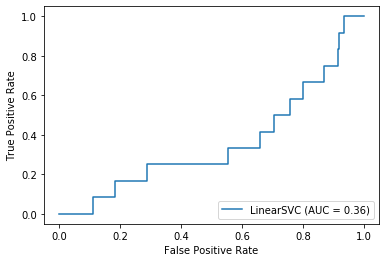

In [77]:
test = plot_roc_curve(linearsvmalone_clf, X_test, y_test)


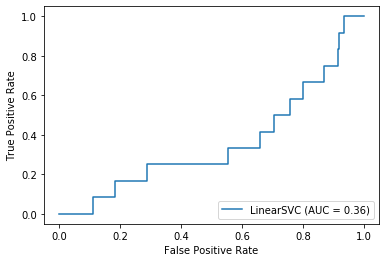

In [78]:
test.plot()


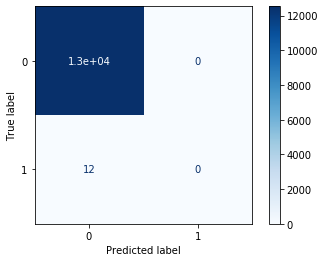

In [88]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(linearsvmalone_clf, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize=None)
# disp.ax_.set_title(title)

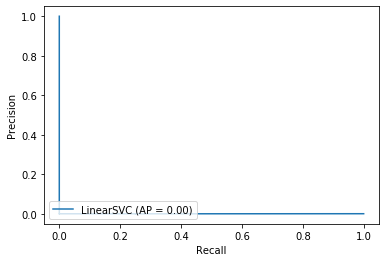

In [90]:
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(linearsvmalone_clf, X_test, y_test)
# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))